In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from models import LS, CG

LS Hessian underpredicts errors by far (see line plots and frequentist). Really is the error for LS fit to the mean, which is narrow, doesn't account for deviations from the mean in the true values.

LS $\sigma_s$ more reasonable, but struggles with correlated errors (as expected) since error assumed constant across run

CG Hessian closer but underpredicts by ~50-80% of true (frequentist) value%. This gets better for simpler likelihoods. Dealing with the mismatch; pretty sure the Hessian is correct, so what is going wrong?

CG has wider peak for more complex likelihoods $\implies$ larger errors in the parameter estimates. Reflects the fact functions like $-X^{2/d}$ are less sensitive to changes in $\theta$ compared to e.g. $y = mx$.

If the actual CG errors were the same as the ones predicted by the Hessian, it would beat LS. 

**How CG does for different types of function**

- Linear, quadratic, sinusoidal: better than LS, Hessian predicts error well

- Log, $X^d$, $-X^{2/d}$, Gaussian $\log L$, Cauchy: same as LS, Hessian underpredicts error 

- Wedding cake: bad, doesn't fit the data

In [3]:
nk = nk_dead_live(500, 500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

### **LS errors**

In [3]:
like = simple
X = generate_Xs(nk)
theta_true = 10
yl = like.func(X, theta_true)
ls = LS(yl, like, mean_X)
theta_l = ls.minimise(theta_true)
Hl = ls.hess(theta_l)
stdl = np.sqrt(-1/Hl[0,0])

(-0.94, -0.93)

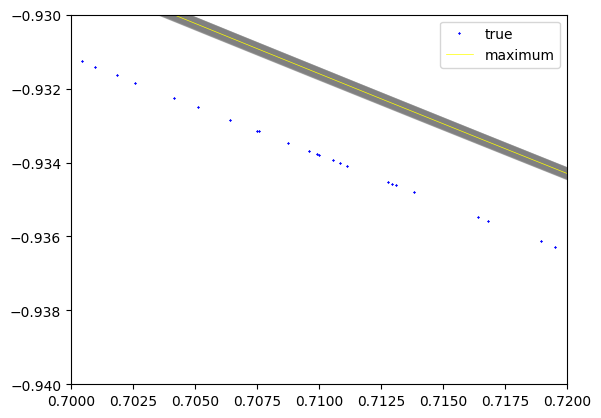

In [4]:
for i in range(200):
    theta = np.random.normal(theta_l, stdl)
    Xl = like.inverse(yl, theta)
    plt.plot(Xl, yl, lw=1, color='gray', alpha=.5)
plt.plot(X, yl, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(yl, theta_l), yl, lw=.5, color='yellow', label='maximum')
plt.legend();
plt.xlim(0.7, 0.72);
plt.ylim(-.94, -.93)

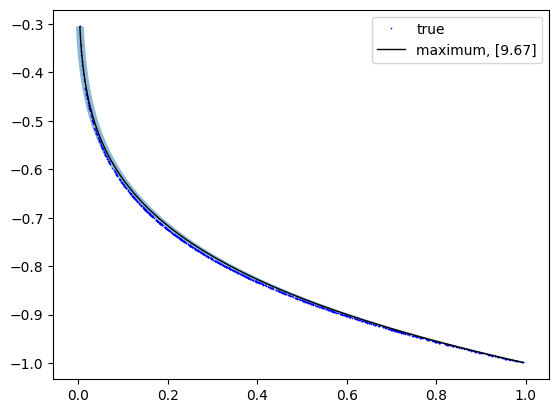

In [5]:
sl = ls.s(theta_l)
Xl = like.inverse(yl, theta_l)
plt.plot(X, yl, 'x', ms=.5, color='blue', label=f'true')
plt.plot(Xl, yl, lw=1, color='black', label=f'maximum, {np.round(theta_l, 2)}')
plt.fill_betweenx(yl, Xl+sl, Xl-sl, alpha=0.5)
plt.legend();
# plt.xlim(0.7, 0.72);
# plt.ylim(-.94, -.93)

### **CG errors**

(-0.94, -0.93)

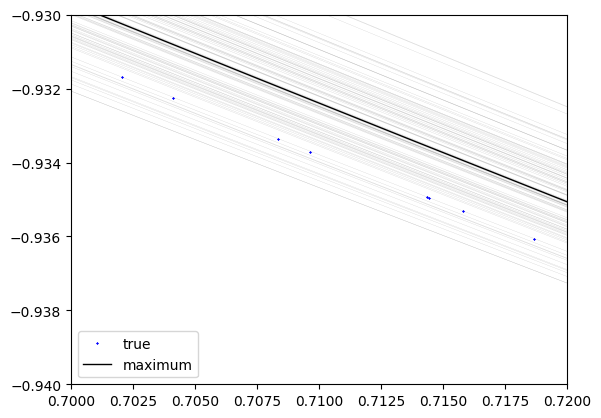

In [115]:
like = simple
X = generate_Xs(nk)
theta_true = 10
y = like.func(X, theta_true)
cg = CG(y, like, mean_X, covinv_X)
theta_c = cg.minimise(theta_true)
Hc = cg.hess(theta_c)
stdc = np.sqrt(-1/Hc)

for i in range(100):
    theta, = np.random.normal(theta_c, stdc)
    Xc = like.inverse(y, theta)
    plt.plot(Xc, y, lw=0.1, color='gray', alpha=0.8)
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(y, theta_c), y, lw=1, color='black', label='maximum')
plt.legend();
plt.xlim(0.7, 0.72);
plt.ylim(-.94, -.93)

### **Frequentist errors**

In [38]:
def sin_like():
    def func(x, theta):
        return np.sin(x/theta)
    def inverse(y, theta, torched=False):
        if torched:
            return torch.arcsin(y)*theta
        return np.arcsin(y)*theta
    def prime(x, theta, torched=False):
        if torched:
            return 1/theta * torch.cos(x/theta)
        return 1/theta * np.cos(x/theta)
    return likelihood(func, inverse, prime)
sin = sin_like()

In [36]:
# Std of d from Hessian
like = sin
X = generate_Xs(nk)
theta_true = 10
yl = like.func(X, theta_true)
ls = LS(yl, like, mean_X)
cg = CG(yl, like, mean_X, covinv_X)
theta_l, theta_c = ls.minimise(theta_true), cg.minimise(theta_true)
Hc = cg.hess(theta_c)
Hl = ls.hess(theta_l)
stdc, stdl = np.sqrt(-1/Hc), np.sqrt(-1/Hl[0,0])
stdc, stdl

(array([[0.01985367]]), 0.00799561699075551)

In [37]:
# Std of d over many repeats
theta_ls = []
theta_cg = []
for i in range(20):
    X = generate_Xs(nk)
    theta_true = 10
    yl = like.func(X, theta_true)
    ls = LS(yl, like, mean_X)
    cg = CG(yl, like, mean_X, covinv_X)
    theta_ls.append(ls.minimise(theta_true))
    theta_cg.append(cg.minimise(theta_true))
print(np.mean(theta_ls), np.std(theta_ls))
print(np.mean(theta_cg), np.std(theta_cg))

10.013510131835938 0.22393916046842233
9.9978271484375 0.019551918537852455


In [9]:
ys = simple.func(X, theta_true)
ls = LS(ys, simple, mean_X)
cg = CG(ys, simple, mean_X, covinv_X)
ls.minimise(10), cg.minimise(10)

(array([10.39123535]), array([10.14733887]))

### **Full likelihood**

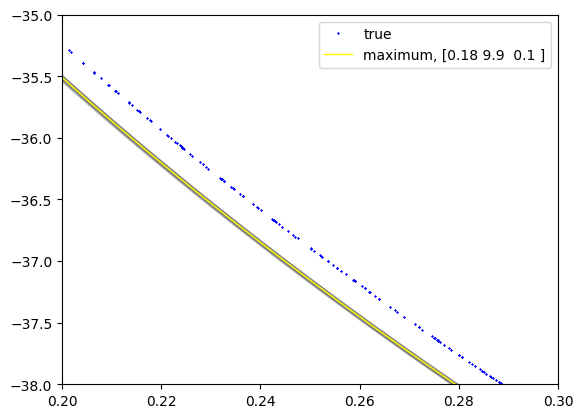

In [26]:
like = full
X = generate_Xs(nk)
theta_true = [1, 10, 0.1]
y = like.func(X, theta_true)
ls = LS(y, like, mean_X)
theta_l = ls.minimise(theta_true)
covl = ls.covtheta(theta_l)

for i in range(100):
    theta = np.random.multivariate_normal(theta_l, covl)
    Xl = like.inverse(y, theta)
    plt.plot(Xl, y, lw=.5, color='gray', alpha=.5)
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(y, theta_l), y, lw=1, color='yellow', label=f'maximum, {np.round(theta_l, 2)}')
plt.legend();
plt.xlim(0.2, 0.3);
plt.ylim(-38, -35);

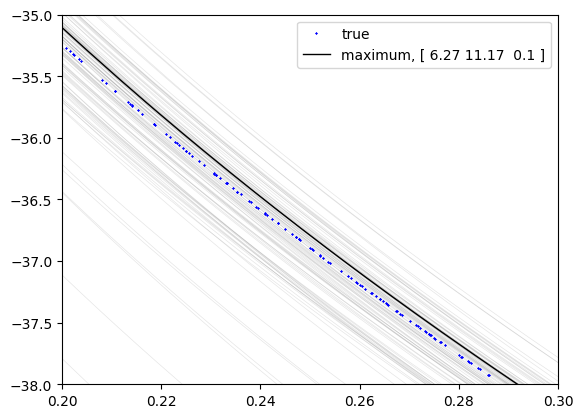

In [121]:
like = full
X = generate_Xs(nk)
theta_true = [1, 10, 0.1]
y = like.func(X, theta_true)
cg = CG(y, like, mean_X, covinv_X)
theta_c = cg.minimise(theta_true)
covc = cg.covtheta(theta_c)

for i in range(100):
    theta = np.random.multivariate_normal(theta_c, covc)
    Xl = like.inverse(y, theta)
    plt.plot(Xl, y, lw=.5, color='gray', alpha=.2)
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(like.inverse(y, theta_c), y, lw=1, color='black', label=f'maximum, {np.round(theta_c, 2)}')
plt.legend();
# plt.xlim(0.7, 0.72);
# plt.yim(-.94, -.93)
plt.xlim(-0.1,1);
plt.xlim(0.2, 0.3);
plt.ylim(-38, -35);

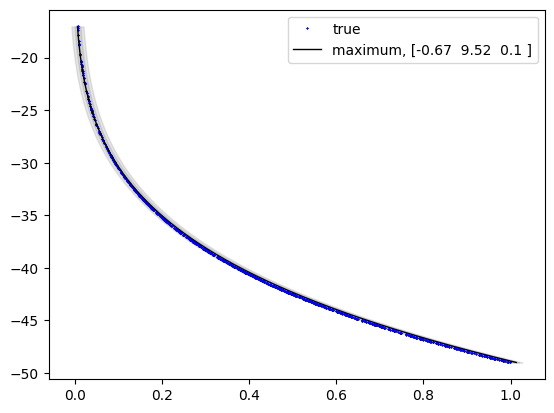

In [108]:
like = full
X = generate_Xs(nk)
theta_true = [1, 10, 0.1]
y = like.func(X, theta_true)
ls = LS(y, like, mean_X)
theta_l = ls.minimise(theta_true)
sl = ls.s(theta_l)
Xl = like.inverse(y, theta_l)

plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(Xl, y, lw=1, color='black', label=f'maximum, {np.round(theta_l, 2)}')
plt.fill_betweenx(y, Xl - sl, Xl + sl, color='gray', alpha=0.2)
plt.fill_betweenx(y, Xl - 2*sl, Xl + 2*sl, color='gray', alpha=0.2)
plt.legend();
# plt.xlim(0.2, 0.3);
# plt.ylim(-38, -35);